In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split

import uproot
import awkward as ak

In [2]:
plt.rc('font', size=14)

In [3]:
# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
class ParamsCVAE(nn.Module):
    def __init__(self, hidden_dim, latent_dim, input_dim, params_dim, label_dim):
        super(ParamsCVAE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim+params_dim+label_dim, hidden_dim, bias=True),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim, bias=True),
            nn.ReLU(),
        )

        self.fc_mu = nn.Linear(hidden_dim, latent_dim, bias=True)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim, bias=True)

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim+params_dim+label_dim, hidden_dim, bias=True),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim, bias=True),
            nn.Sigmoid(),
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, hist, params, labels):
        x = hist.view(hist.size(0), -1)
        x = torch.cat((x, params, labels), dim=1)
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        z = torch.cat((z, params, labels), dim=1)
        reco_hist = self.decode(z)
        return reco_hist, mu, logvar

In [5]:
class CVAELoss(nn.Module):
    def __init__(self):
        super(CVAELoss, self).__init__()

    def forward(self, reco_hist, hist, mu, logvar):
        hist = hist.view(hist.size(0), -1)
        reco_fn = nn.BCELoss(reduction="sum")
        reconstruction = reco_fn(reco_hist, hist)
        kl_divergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return (reconstruction + kl_divergence)/reco_hist.size(0)

In [6]:
# Load histograms

X0_tree = uproot.open("MCHist.root:X0_train")
X0 = X0_tree["hist"].array(library="np")
theta0 = X0_tree["thetas"].array(library="np")
Y0 = X0_tree["label"].array(library="np")

X1_tree = uproot.open("MCHist.root:X1_train")
X1 = X1_tree["hist"].array(library="np")
theta1 = X1_tree["thetas"].array(library="np")
Y1 = X1_tree["label"].array(library="np")

hist = np.concatenate((X0, X1))
thetas = np.concatenate((theta0, theta1))
label = np.concatenate((Y0, Y1))

In [7]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs, early_stopping_patience):

    model = model.to(device)
    
    best_loss = float('inf')
    best_model_weights = None
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for batch_hist, batch_params, batch_labels in train_loader:
            batch_hist = batch_hist.to(device)
            batch_params = batch_params.to(device)
            batch_labels = batch_labels.to(device)

            optimizer.zero_grad()
            reco_hist, mu, logvar = model(batch_hist, batch_params, batch_labels)
            loss = criterion(reco_hist, batch_hist, mu, logvar)

            loss.backward()
            optimizer.step()
            running_loss += loss.item() * batch_hist.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)

        # Evaluation
        model.eval()
        with torch.no_grad():
            running_loss = 0.0
            for batch_hist, batch_params, batch_labels in val_loader:
                batch_hist = batch_hist.to(device)
                batch_params = batch_params.to(device)
                batch_labels = batch_labels.to(device)

                reco_hist, mu, logvar = model(batch_hist, batch_params, batch_labels)
                loss = criterion(reco_hist, batch_hist, mu, logvar)

                running_loss += loss.item() * batch_hist.size(0)

            validation_loss = running_loss / len(val_loader.dataset)

            # print("Epoch {}: Train Loss = {:.4f}, Test Loss = {:.4f}".format(epoch + 1, epoch_loss, validation_loss))

            # Check for early stopping
            if validation_loss < best_loss:
                best_loss = validation_loss
                best_model_weights = model.state_dict()
                patience_counter = 0
            else:
                patience_counter += 1

            if patience_counter >= early_stopping_patience:
                print("Early stopping at epoch {}".format(epoch))
                break

    return best_model_weights

In [8]:
# module used to add parameter for fitting
class AddParams2Input(nn.Module):
    def __init__(self, params):
        super(AddParams2Input, self).__init__()
        self.params = nn.Parameter(torch.Tensor(params), requires_grad=True)

    def forward(self, inputs):
        batch_params = torch.ones((inputs.size(0), 1), device=inputs.device) * self.params.to(device=inputs.device)
        return inputs, batch_params

In [9]:
# Test histograms

X0_test = uproot.open("MCHist.root:X0_test")
X0 = X0_test["hist"].array(library="np")
theta0 = X0_test["thetas"].array(library="np")
Y0 = X0_test["label"].array(library="np")

X1_test = uproot.open("MCHist.root:X1_test")
X1 = X1_test["hist"].array(library="np")
theta1 = X1_test["thetas"].array(library="np")
Y1 = X1_test["label"].array(library="np")

hist = np.concatenate((X0, X1))
thetas = np.concatenate((theta0, theta1))
label = np.concatenate((Y0, Y1))

In [10]:
# Fit the model
def fit_fn(num_epochs, add_params_layer, params_cvae, data_loader, device, optimizer, loss_fn):
    losses = []
    fit_vals = {"lambda": [], "mu": [], "nu": []}

    add_params_layer = add_params_layer.to(device)
    params_cvae = params_cvae.to(device)

    for epoch in range(num_epochs):
        add_params_layer.train()
        running_loss = 0.0
        for batch_hist, batch_labels in data_loader:
            batch_hist = batch_hist.to(device)
            batch_labels = batch_labels.to(device)

            # Forward pass
            optimizer.zero_grad()
            batch_inputs, batch_params = add_params_layer(batch_hist)
            output, mu, logvar = params_cvae(batch_hist, batch_params, batch_labels)

            # Compute the loss
            loss = loss_fn(output, batch_hist, mu, logvar)

            # Backward pass and update weights
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * batch_inputs.size(0)

        epoch_loss = running_loss / len(data_loader.dataset)
        # print("epoch : {}, loss = {:.4f}, nu = {:.4f}".format(epoch + 1, epoch_loss, add_params_layer.params[2].item()))
        losses.append(epoch_loss)
        fit_vals["lambda"].append(add_params_layer.params[0].item())
        fit_vals["mu"].append(add_params_layer.params[1].item())
        fit_vals["nu"].append(add_params_layer.params[2].item())

    return losses, fit_vals

In [11]:
batch_size = 1024
input_dim = 20*20
hidden_dim = 128
latent_dim = 32
params_dim = 3
label_dim = 2
num_epochs = 200
learning_rate = 0.001
early_stopping_patience = 20
iterations = 40

In [12]:
opt_params = {"lambda": [], "mu": [], "nu": []}

for iteration in range(iterations):

    print("===> Iteration {}".format(iteration))

    # split train and validation
    X_train, X_val, theta_train, theta_val, label_train, label_val = train_test_split(hist, thetas, label, test_size=0.4, shuffle=True)

    X_train_tensor = torch.from_numpy(X_train).float()
    X_val_tensor = torch.from_numpy(X_val).float()
    theta_train_tensor = torch.from_numpy(theta_train).float()
    theta_val_tensor = torch.from_numpy(theta_val).float()
    label_train_tensor = torch.from_numpy(label_train).float()
    label_val_tensor = torch.from_numpy(label_val).float()
    
    # make data set
    train_dataset = TensorDataset(X_train_tensor, theta_train_tensor, label_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, theta_val_tensor, label_val_tensor)
    
    # make data loaders
    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    params_cvae = ParamsCVAE(hidden_dim, latent_dim, input_dim, params_dim, label_dim)

    print("*** Training step ***")

    # Model summary
    # print("using device : {}".format(device))
    # total_trainable_params = sum(p.numel() for p in params_cvae.parameters() if p.requires_grad)
    # print(params_cvae)
    # print('total trainable params: {}'.format(total_trainable_params))

    criterion = CVAELoss()
    optimizer = optim.Adam(params_cvae.parameters(), lr=learning_rate)

    best_model_weights = train_model(params_cvae, train_dataloader, val_dataloader, criterion, optimizer, device, num_epochs, early_stopping_patience)

    # Convert to tensor
    hist_tensor = torch.from_numpy(hist).float()
    thetas_tensor = torch.from_numpy(thetas).float()
    label_tensor = torch.from_numpy(label).float()
    
    test_dataset = TensorDataset(hist_tensor, label_tensor)
    test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

    print("*** Fitting step ***")

    # Load the best model weights
    params_cvae.load_state_dict(best_model_weights)
    
    # Define the parameters
    mu_fit_init = [np.random.uniform(0., 2., 1)[0], np.random.uniform(-1., 1., 1)[0], np.random.uniform(-1., 1., 1)[0]]
    
    # Create the AddParams2Input layer
    add_params_layer = AddParams2Input(mu_fit_init)

    # Set all weights in fit model to non-trainable
    for param in params_cvae.parameters():
        param.requires_grad = False

    # Model summary
    # print("using device : {}".format(device))
    # fit_trainable_params = sum(p.numel() for p in params_cvae.parameters() if p.requires_grad)
    # print(params_cvae)
    # print('total trainable params in fit model: {}'.format(fit_trainable_params))
    
    # total_trainable_params = sum(p.numel() for p in add_params_layer.parameters() if p.requires_grad)
    # print(add_params_layer)
    # print('total trainable params in fit model: {}'.format(total_trainable_params))

    criterion = CVAELoss()
    optimizer = optim.Adam(add_params_layer.parameters(), lr=learning_rate)

    loss, fit_vals = fit_fn(num_epochs, add_params_layer, params_cvae, test_dataloader, device, optimizer, criterion)

    opt_params["lambda"].append(fit_vals["lambda"][-1])
    opt_params["mu"].append(fit_vals["mu"][-1])
    opt_params["nu"].append(fit_vals["nu"][-1])

    print("===> Target = ({:.2f}, {:.2f}, {:.2f}) -> Fit = ({:.3f} +/- {:.3f}, {:.3f} +/- {:.3f}, {:.3f} +/- {:.3f})".format(0.8, -0.1, 0.2,
                                                                                                                             np.mean(opt_params["lambda"]), np.std(opt_params["lambda"]),
                                                                                                                             np.mean(opt_params["mu"]), np.std(opt_params["mu"]),
                                                                                                                             np.mean(opt_params["nu"]), np.std(opt_params["nu"])))

===> Iteration 0
*** Training step ***
*** Fitting step ***
===> Target = (0.80, -0.10, 0.20) -> Fit = (0.918 +/- 0.000, -0.016 +/- 0.000, 0.116 +/- 0.000)
===> Iteration 1
*** Training step ***
*** Fitting step ***
===> Target = (0.80, -0.10, 0.20) -> Fit = (0.904 +/- 0.014, -0.038 +/- 0.021, 0.109 +/- 0.007)
===> Iteration 2
*** Training step ***
Early stopping at epoch 198
*** Fitting step ***
===> Target = (0.80, -0.10, 0.20) -> Fit = (0.905 +/- 0.011, -0.037 +/- 0.017, 0.108 +/- 0.006)
===> Iteration 3
*** Training step ***
Early stopping at epoch 180
*** Fitting step ***
===> Target = (0.80, -0.10, 0.20) -> Fit = (0.903 +/- 0.010, -0.050 +/- 0.027, 0.096 +/- 0.021)
===> Iteration 4
*** Training step ***
*** Fitting step ***
===> Target = (0.80, -0.10, 0.20) -> Fit = (0.875 +/- 0.056, -0.035 +/- 0.040, 0.147 +/- 0.103)
===> Iteration 5
*** Training step ***
Early stopping at epoch 195
*** Fitting step ***
===> Target = (0.80, -0.10, 0.20) -> Fit = (0.877 +/- 0.052, -0.036 +/- 0.03

In [13]:
outfile = uproot.recreate("results.root", compression=uproot.ZLIB(4))
outfile["opt_params"] = opt_params
outfile.close()

In [14]:
%%bash

root -b -q Plots.cc

/home/dinupa/mambaforge/envs/BMFNet/etc/cling/std.modulemap:257:29: warning: unknown attribute 'optional' [-Wignored-attributes]
  module "memory_resource" [optional] {
                            ^
/home/dinupa/mambaforge/envs/BMFNet/etc/cling/std.modulemap:447:27: warning: unknown attribute 'optional' [-Wignored-attributes]
  module "bits/chrono.h" [optional] {
                          ^
/home/dinupa/mambaforge/envs/BMFNet/etc/cling/std.modulemap:531:41: warning: unknown attribute 'optional' [-Wignored-attributes]
  explicit module "bits_ranges_base_h" [optional] {
                                        ^
/home/dinupa/mambaforge/envs/BMFNet/etc/cling/std.modulemap:538:32: warning: unknown attribute 'optional' [-Wignored-attributes]
  module "bits/ranges_util.h" [optional] {
                               ^
/home/dinupa/mambaforge/envs/BMFNet/etc/cling/std.modulemap:559:40: warning: unknown attribute 'optional' [-Wignored-attributes]
  module "bits/uses_allocator_args.h" [optional] 

   ------------------------------------------------------------------
  | Welcome to ROOT 6.28/04                        https://root.cern |
  | (c) 1995-2022, The ROOT Team; conception: R. Brun, F. Rademakers |
  | Built for linuxx8664gcc on Jul 15 2023, 14:25:00                 |
  | From tag , 8 May 2023                                            |
  | With                                                             |
  | Try '.help'/'.?', '.demo', '.license', '.credits', '.quit'/'.q'  |
   ------------------------------------------------------------------


Processing Plots.cc...
 FCN=2.63239 FROM MIGRAD    STATUS=CONVERGED      79 CALLS          80 TOTAL
                     EDM=1.02487e-08    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.88279e+01   4.09653e+00   2.86690e-03  -3.28727e-05
   2  Mean         9.14416e-01   1.

Info in <TCanvas::Print>: png file imgs/opt_lambda_4.png has been created


 FCN=3.91381 FROM MIGRAD    STATUS=CONVERGED     101 CALLS         102 TOTAL
                     EDM=3.01088e-07    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     2.69137e+01   5.26313e+00   4.84790e-03  -5.32499e-06
   2  Mean        -4.68562e-02   9.23193e-03   1.00129e-05   1.51475e-02
   3  Sigma        5.30914e-02   5.93761e-03   2.44305e-05  -2.93499e-02


Info in <TCanvas::Print>: png file imgs/opt_mu_4.png has been created


 FCN=6.35253 FROM MIGRAD    STATUS=CONVERGED      80 CALLS          81 TOTAL
                     EDM=1.33802e-09    STRATEGY= 1      ERROR MATRIX ACCURATE 
  EXT PARAMETER                                   STEP         FIRST   
  NO.   NAME      VALUE            ERROR          SIZE      DERIVATIVE 
   1  Constant     1.56385e+01   4.07911e+00   3.57081e-03  -8.62507e-06
   2  Mean         8.04676e-02   1.48969e-02   1.95925e-05   1.41356e-03
   3  Sigma        8.58359e-02   1.67866e-02   4.34033e-05  -1.31051e-03


Info in <TCanvas::Print>: png file imgs/opt_nu_4.png has been created


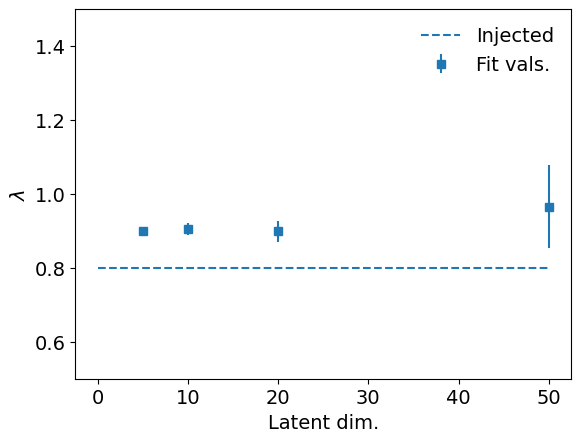

In [27]:
# Test lambda with latent dim

opt_lambda = np.array([0.899, 0.9043, 0.8984, 0.9651])
opt_lambda_err = np.array([0.009, 0.016, 0.0278, 0.112])
latent_dim = np.array([5, 10, 20, 50])

plt.hlines(0.8, 0, 50, label="Injected", linestyles="dashed")
plt.errorbar(latent_dim, opt_lambda, yerr=opt_lambda_err, fmt="s", label="Fit vals.")
plt.ylim(0.5, 1.5)
plt.xlabel("Latent dim.")
plt.ylabel(r"$\lambda$")
plt.legend(frameon=False)
plt.savefig("imgs/test0_lambda.png")
plt.show()

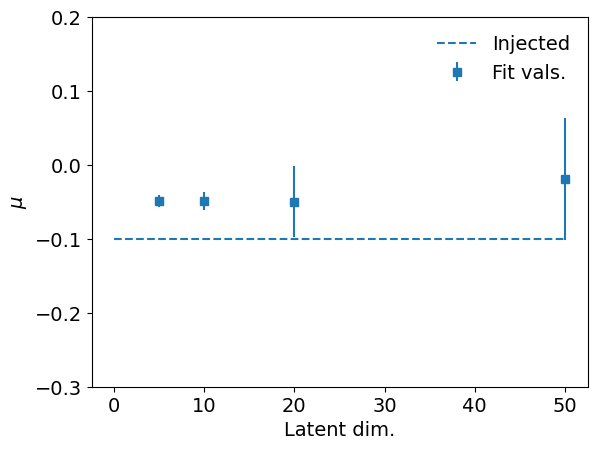

In [28]:
opt_mu = np.array([-0.04832, -0.04858, -0.0495, -0.01927])
opt_mu_err = np.array([0.007923, 0.01188, 0.04753, 0.08243])
latent_dim = np.array([5, 10, 20, 50])

plt.hlines(-0.1, 0, 50, label="Injected", linestyles="dashed")
plt.errorbar(latent_dim, opt_mu, yerr=opt_mu_err, fmt="s", label="Fit vals.")
plt.ylim(-0.3, 0.2)
plt.xlabel("Latent dim.")
plt.ylabel(r"$\mu$")
plt.legend(frameon=False)
plt.savefig("imgs/test0_mu.png")
plt.show()

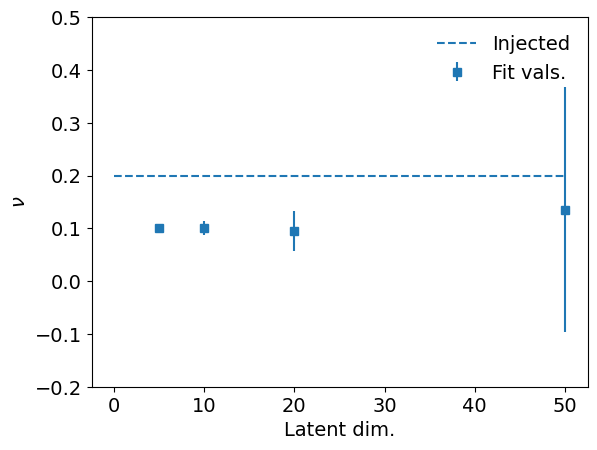

In [29]:
opt_nu = np.array([0.1014, 0.1005, 0.095, 0.1356])
opt_nu_err = np.array([0.006888, 0.01367, 0.03819, 0.232])
latent_dim = np.array([5, 10, 20, 50])

plt.hlines(0.2, 0, 50, label="Injected", linestyles="dashed")
plt.errorbar(latent_dim, opt_nu, yerr=opt_nu_err, fmt="s", label="Fit vals.")
plt.ylim(-0.2, 0.5)
plt.xlabel("Latent dim.")
plt.ylabel(r"$\nu$")
plt.legend(frameon=False)
plt.savefig("imgs/test0_nu.png")
plt.show()